## Plotting City Building Footprints and Street Networks with OSMnx

This notebook is built on the notebook "Street Colouring with OSMnx" from @puntofisso

https://github.com/puntofisso/OSMnxNotebooks/blob/master/Street%20colouring.ipynb

I left the original description of his notebook here.

>### Street Colouring with OSMnx
>This was inspired by previous work by Erin Davis and Cedric Scherer.

>* [The beautiful hidden logic of cities](https://erdavis.com/2019/07/27/the-beautiful-hidden-logic-of-cities/)
>* [#Berlin road network by name/suffix forming colorful networks](https://twitter.com/CedScherer/status/1195420409434382336)
>* [Erin's code](https://github.com/erdavis1/RoadColors)
>* [Cedric's code](https://github.com/Z3tt/30DayMapChallenge)

>Their code is very interesting in that it shows how to manipulate shapefiles in R in order to extract the data >and chart. However, R is not my first language (I speak Python slightly better), and I'm a notorious big fan of >OSMnx, so I wanted to see if this could be replicated with my favourite set of tools.

>**TL;DR**: it can, and it only takes a few lines of code.

>For comparison and reference, Cedric's version is the one I aimed to replicate directly:

### My Contribution

I combined the street network with the city buildings to plot a nice looking representation for cities.  
I was hoping that one should be able to build on this to make a nice map of most cities, but I get errors and timeouts for most other towns I tried.  
If you know your way around that and can make it work, I would be happy to know!

I used the 'building' description from the footprint data to color each building based on it's use.

White building and street outlines on a colored background or as colored outlines on a dark background look fantastic too. Try it out for yourself!

Let me know on Twitter (@danzn1) when you make a nice map!

In [1]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
ox.config(log_console=True, use_cache=True)

%config InlineBackend.figure_format = "retina"

fontname = "Enigmatic Unicode"

### Plotting the streetmap

In [38]:
# simple qualitative colormap
set1 = ["#e41a1c","#377eb8","#4daf4a","#984ea3","#ff7f00","#ffff33","#a65628","#f781bf","#999999"]

# categorization of building uses
housing = ['yes', 'apartments', 'house', 'residential', 'detached', 'semidetached_house', 'dormitory',
           'static_caravan', 'semi', 'bungalow', 'hotel', 'roof', 'terrace', 'pavilion']
transportation = ['garages', 'garage', 'carport', 'transportation', 'parking', 'train_station', 'bridge']
schrebergaerten = ['allotment_house', 'alotment_house']
industrial = ['industrial', 'warehouse', 'manufacture', 'construction']
retail = ['retail', 'service', 'commercial', 'kiosk', 'supermarket']
community = ['school', 'mosque', 'church', 'stadium', 'religious', 'chapel', 'hospital', 'kindergarten',
             'riding_hall', 'sports_hall', 'grandstand', 'sports_centre', 'community_centre', 'civic',
             'government', 'public']
offices = ['office']
higher_education = ['university', 'college']
huts = ['cabin', 'farm', 'slurry_tank', 'stable', 'barn', 'shed', 'hut', 'greenhouse', 'farm_auxiliary',
        'farm_auxilary', 'greehhouse', 'ruins', 'bunker', 'collapsed', 'storage_tank']

house_type_names = ['Industrie',
                    'Büros',
                    'Schrebergärten',
                    'Gemeinde',
                    'Retail',
                    'Hochschulen',
                    'Schuppen',
                    'Wohnen',
                    'Verkehrswesen'
                   ]

house_types = [industrial,
               offices,
               schrebergaerten,
               community,
               retail,
               higher_education,
               huts,
               housing,
               transportation
             ]

def savefig(path, filename, dpi = 250, facecolor = None, **kwargs):
    import os
    if facecolor is None:
        facecolor = plt.gcf().get_facecolor()
        
    if os.path.isdir(path) == False:
        os.makedirs(path)                 

    plt.savefig("/".join([path, filename]),
                dpi = dpi, facecolor = facecolor, **kwargs)

def add_housing_type(gdf):
    gdf['house_type_color'] = np.nan
    gdf['house_type_name'] = np.nan

    for i, house_type in enumerate(house_types):
        gdf.loc[gdf.building.isin(house_type), 'house_type_color'] = set1[i]
        gdf.loc[gdf.building.isin(house_type), 'house_type_name'] = house_type_names[i]

    gdf['house_type_name'] = gdf['house_type_name'].fillna('Wohnen')
    gdf['house_type_color'] = gdf['house_type_color'].fillna(set1[-2])

    return gdf


def make_city_housingtype_map(place,
                              bg_color = 'w',
                              street_color = '#d9d9d9',
                              fontcolor = 'k',
                              title = None,
                              subtitle = None):
    if title is None:
        title = place.split(',')[0]
    if subtitle is None:
        subtitle = place.split(',')[-1]
    
    gdf = ox.footprints.footprints_from_place(place=place, which_result=0)
    G = ox.graph_from_place(place, network_type='all', which_result=0)
    
    gdf = add_housing_type(gdf)
    
    fig, ax = ox.plot_graph(G,
                          bgcolor=bg_color,
                          axis_off=True,
                          node_size=0,
                          node_color=street_color,
                          node_edgecolor=street_color,
                          node_zorder=2,
                          edge_color=street_color,
                          edge_linewidth=0.5,
                          edge_alpha=1,
                          fig_height=20,
                          dpi=300)

    fig.set_size_inches(16, 16)
    ax.set_aspect(1.5)

    ylim = ax.get_ylim()
    y_extent = ylim[1] - ylim[0]
    ax.set_ylim(ylim[0] - 0.3*y_extent, ylim[1] + 0.15*y_extent)

    current_xlim = ax.get_xlim()
    current_ylim = ax.get_ylim()

    city, country = place.split(',')
    fig.text(s=title, x=0.5, y=0.21, fontsize=64, fontname=fontname, ha='center', color = fontcolor)
    fig.text(s=subtitle, x=0.5, y=0.185, fontsize=18, fontname=fontname, ha='center', color = fontcolor)
    ax.plot([current_xlim[0] + 0.335 * (current_xlim[1] - current_xlim[0]),
              current_xlim[0] + 0.635 * (current_xlim[1] - current_xlim[0])],
             [current_ylim[0] + 0.075 * (current_ylim[1] - current_ylim[0]),
              current_ylim[0] + 0.075 * (current_ylim[1] - current_ylim[0])],
             '-',
             color = fontcolor,
             lw = 2.5);

    fig, ax = ox.footprints.plot_footprints(gdf,
                                            fig=fig,
                                            ax=ax,
                                            color=gdf['house_type_color'],
                                            set_bounds=True,
                                            dpi=300)
    
    x_range = current_xlim[1] - current_xlim[0]
    y_range = current_ylim[1] - current_ylim[0]

    scatter_x_range = 0.6*x_range

    scatter_xs1 = current_xlim[0] + 0.375 * scatter_x_range + np.linspace(0, scatter_x_range, 6)[:5]
    scatter_xs2 = current_xlim[0] + 0.3 * scatter_x_range + np.linspace(0, scatter_x_range, 7)[1:5]

    scatter_ys1 = np.array(5 * [0.165]) * y_range + current_ylim[0]
    scatter_ys2 = np.array(4 * [0.115]) * y_range + current_ylim[0]

    ax.scatter(scatter_xs1, scatter_ys1, c=set1[:5], s = 50)
    ax.scatter(scatter_xs2, scatter_ys2, c=set1[5:], s = 50)

    for i, name in enumerate(house_type_names[:5]):
        ax.text(s=name, x=scatter_xs1[i]+0.0025, y=scatter_ys1[0], fontname = fontname, va = 'center', fontsize = 12, color = fontcolor)

    for i, name in enumerate(house_type_names[5:]):
        ax.text(s=name, x=scatter_xs2[i]+0.0025, y=scatter_ys2[0], fontname = fontname, va = 'center', fontsize = 12, color = fontcolor)

    ax.set_ylim(current_ylim[0]-0.025*y_range, current_ylim[1])
    
    return fig, ax, G, gdf

In [45]:
fig, ax, G, gdf = make_city_housingtype_map('Bochum, Germany')

ReadTimeout: HTTPConnectionPool(host='overpass-api.de', port=80): Read timed out. (read timeout=180)

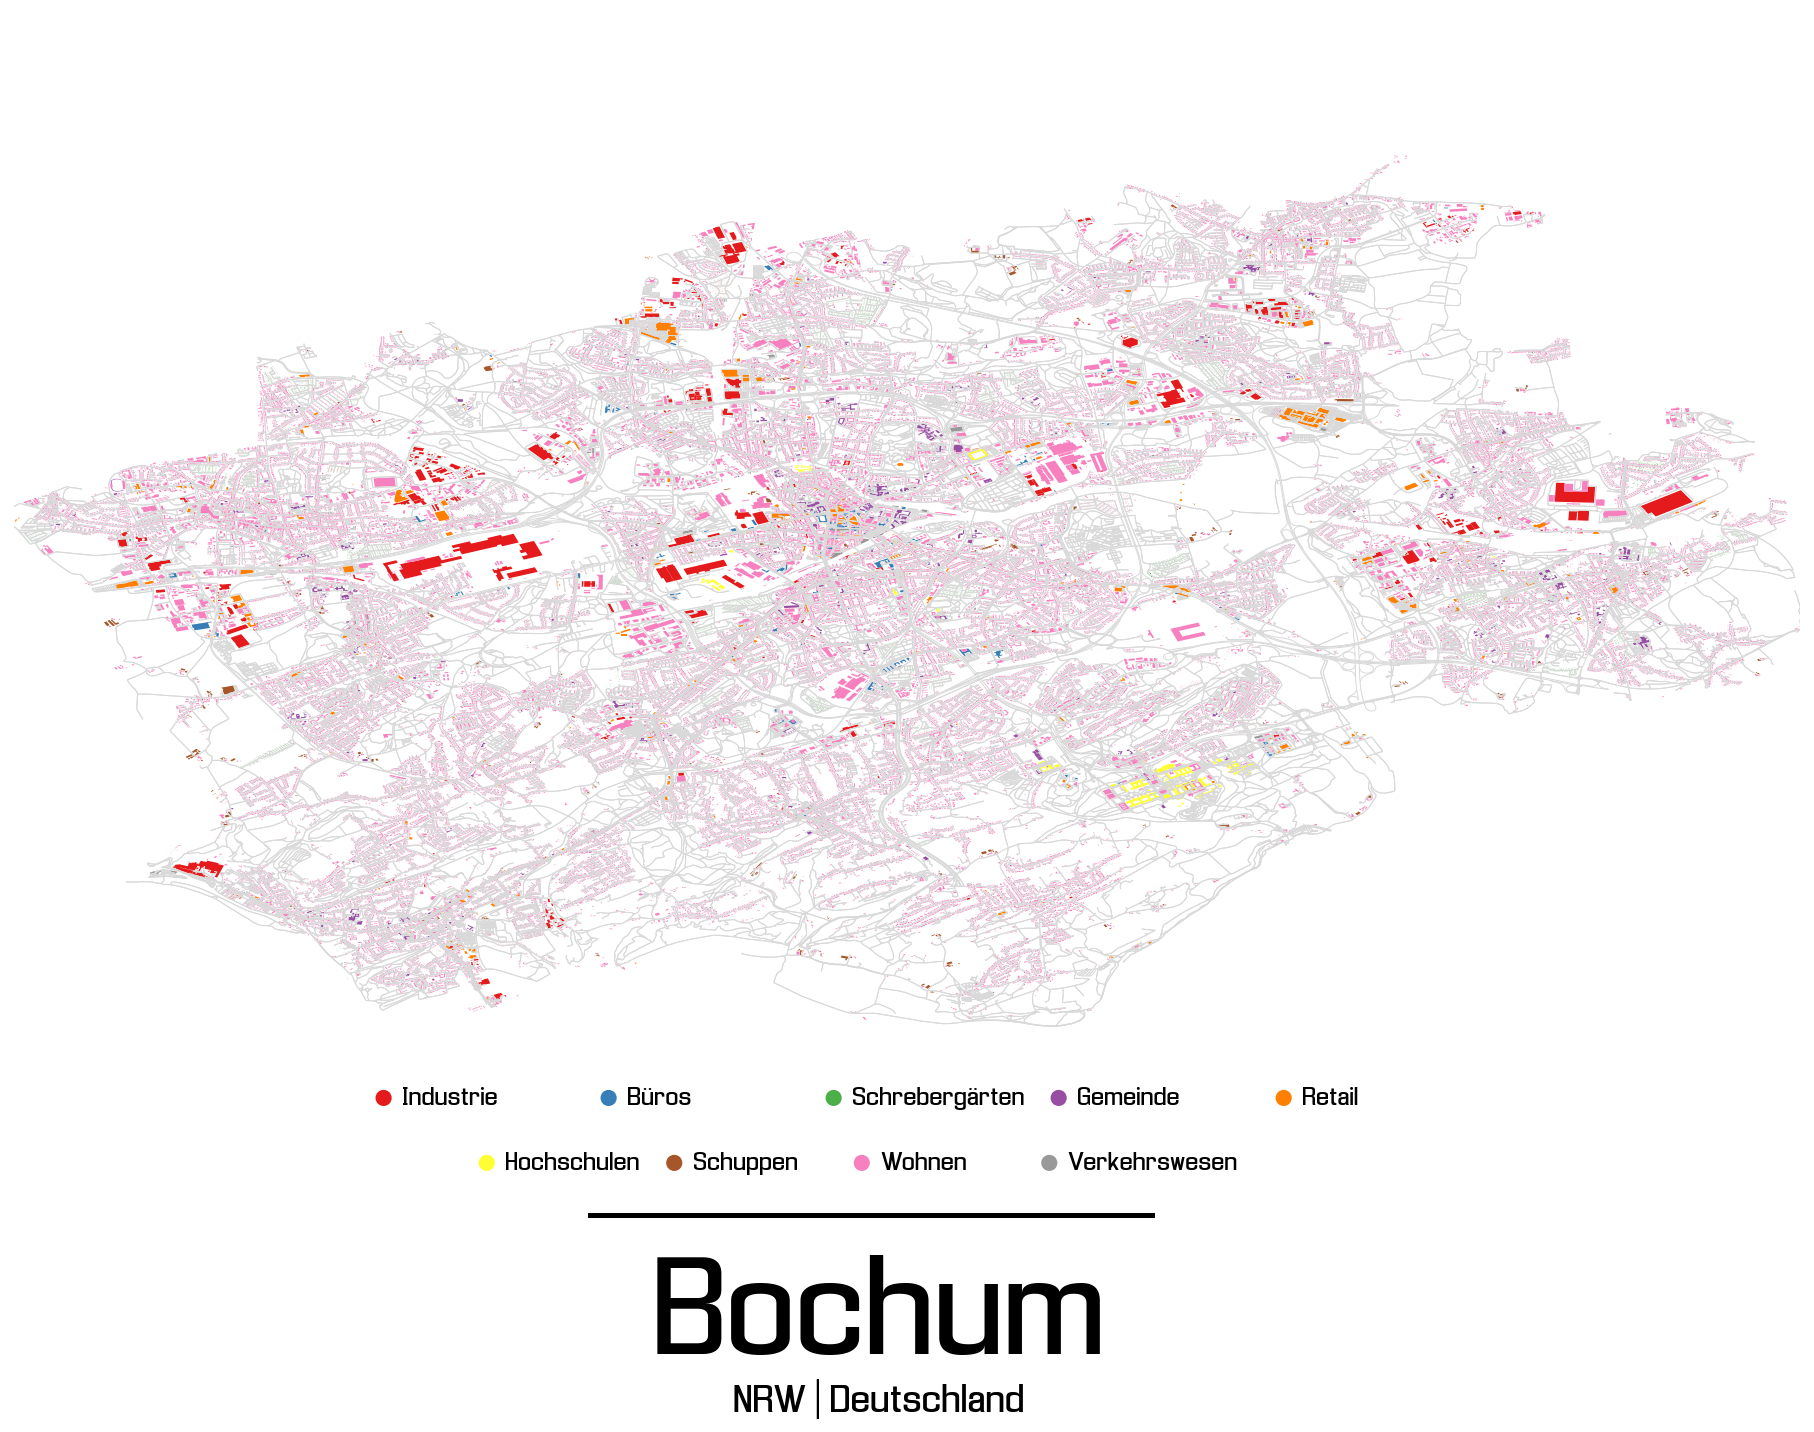

In [9]:
fig